# Save Models

Use this notebook to save models locally to the directory `~/aie_demo_playground/saved_models` (where this file is saved). If you do not want to save models this way, please ensure that they are saved so they can be accessed by the Hugging Face transformers pyhton library. 

## Set up cache

This can be helpful when using a server where the `/tmp` folder (that the Hugging Face transformers library uses while saving files) has limited space, and can be substituted for a different folder. Do this **before** importing the transformers library. See this [stackoverflow post](https://stackoverflow.com/questions/63312859/how-to-change-huggingface-transformers-default-cache-directory) for more information. 

In [1]:
# Set up cache in which to save models
import os
os.environ['TRANSFORMERS_CACHE'] = '[INSERT PATH TO DIR]'

In [ ]:
# Imports
import torch
import configparser
from datasets import load_dataset
from transformers import (pipeline, 
                          AutoModelForCausalLM, 
                          AutoTokenizer, 
                          SpeechT5Processor, 
                          SpeechT5ForTextToSpeech, 
                          SpeechT5HifiGan)
from sentence_transformers import SentenceTransformer
import soundfile as sf

In [3]:
# Added as per https://colab.research.google.com/drive/1ge2F1QSK8Q7h0hn3YKuBCOAS0bK8E0wf#scrollTo=WQ-BLtJG9b38
from torch import bfloat16
from transformers import BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=bfloat16
)

In [6]:
# Set path for saved models
path_saved_models = os.getcwd()

In [7]:
# Helper function to save model
def save_model(model_name, pipe, path_saved_models=path_saved_models):
    '''
    Save a Hugging Face model to path_saved_models.

    Args:
        model_name (str): Name of model being saved. Stick to the 
            Hugging Face names. 
        pipe (transformers.pipelines.text_generation.TextGenerationPipeline): 
            Hugging Face pipeline with model. 
        path_saved_models (str): Dir where models are saved.

    Returns:
        None
    '''
    # Create path for model if not existing, else error out
    path_model_save = os.path.join(path_saved_models, model_name)
    if not os.path.exists(path_model_save):
        os.mkdir(path_model_save)
    else:
        raise ValueError(f"Already exists and will not be saved over: {path_model_save}")
    
    # Set save paths
    path_model_save_model     = os.path.join(path_model_save, 'model')
    path_model_save_tokenizer = os.path.join(path_model_save, 'tokenizer')

    # Get the model and tokenizer
    model     = pipe.model
    tokenizer = pipe.tokenizer

    # Save the model and tokenizer to disk
    model.save_pretrained(path_model_save_model)
    tokenizer.save_pretrained(path_model_save_tokenizer)

    # Print message
    print(f"Successfully saved {model_name}")

# [Mistral-7B-Instruct-v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2) 

Running this requires both a Hugging Face access token, and to agree to the prompt (image below) on the website https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2

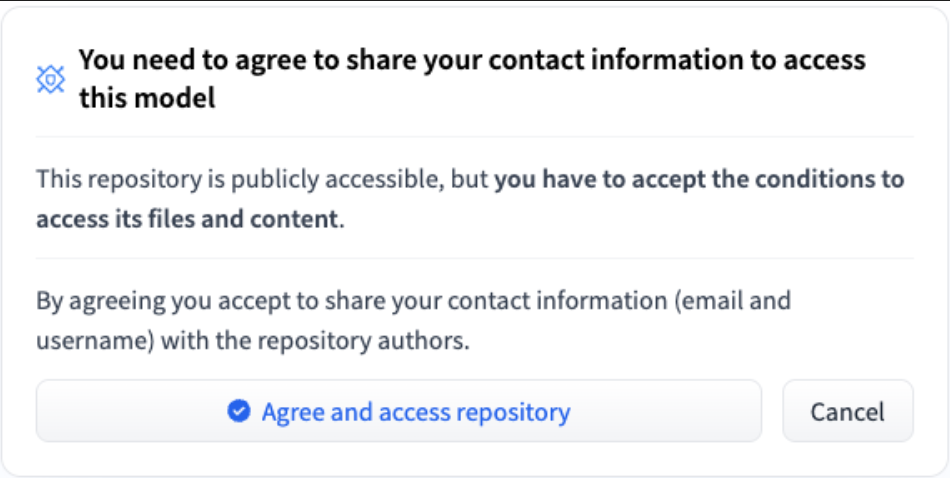

In [5]:
model_name = 'Mistral-7B-Instruct-v0.2'

## Save

In [ ]:
pipe = pipeline("text-generation", model=f"mistralai/{model_name}", token="[INSERT YOUR HUGGING FACE TOKEN HERE]")

In [ ]:
# Save model
save_model(model_name, pipe)

## Load

In [9]:
# Set model paths 
path_model_save           = os.path.join(path_saved_models, model_name)
path_model_save_model     = os.path.join(path_model_save, 'model')
path_model_save_tokenizer = os.path.join(path_model_save, 'tokenizer')

## Test

In [ ]:
# loading the model after its been saved locally
model     = AutoModelForCausalLM.from_pretrained(path_model_save_model, quantization_config=bnb_config, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(path_model_save_tokenizer)

In [ ]:
prompt = "Tell me about gravity"

In [12]:
model_inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

In [ ]:
output = model.generate(**model_inputs, 
                        max_new_tokens=2048)

In [ ]:
print(tokenizer.decode(output[0], skip_special_tokens=True))

# [BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5)

In [7]:
model_name = 'BAAI/bge-small-en-v1.5'

## Save

In [ ]:
model = SentenceTransformer("BAAI/bge-small-en-v1.5")

In [ ]:
# Create path for model if not existing, else error out
path_model_save = os.path.join(path_saved_models, model_name)
# Set save paths
path_model_save_model = os.path.join(path_model_save, 'model')
# Save the model and tokenizer to disk
model.save(path_model_save_model)
# Print message
print(f"Successfully saved {model_name}")

# [microsoft/speecht5_tts](https://huggingface.co/microsoft/speecht5_tts)

In [9]:
model_name = "speecht5_tts"

## Save

In [ ]:
pipe = pipeline("text-to-speech", model=f"microsoft/{model_name}")

In [ ]:
# Save model
save_model(model_name, pipe)

In [12]:
# Set model paths 
path_model_save           = os.path.join(path_saved_models, model_name)
path_model_save_model     = os.path.join(path_model_save, 'model')
path_model_save_tokenizer = os.path.join(path_model_save, 'tokenizer')

## Test

In [ ]:
processor = SpeechT5Processor.from_pretrained(path_model_save_model)
model = SpeechT5ForTextToSpeech.from_pretrained(path_model_save_model)
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [ ]:
inputs = processor(text="Hello, my dog is cute.", return_tensors="pt")

In [ ]:
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

In [ ]:
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [ ]:
sf.write("speech.wav", speech.numpy(), samplerate=16000)